In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
DEVICE = torch.device('cpu')

NAME = 'ladle_furnace_inference'

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. 


## **Building scenarios with different detector configurations**

We'll begin by defining the **number of simulations** we want to produce, their individual **data taking time**, and the considered **flux of muons**.

In [2]:
Simulations = 100 # number of simulations
Time = 5 # muography measurement time of a single simulation [min]
Flux = 6845 # considered flux of muons [muons/(min*m^2)]

Then, we will continue defining 4 scenarios with different detector configurations. Each scenario corresponds to a **volume**, consisting of the configured **detectors** and a **passive volume**. 

In [3]:
from tomopt.volume import Volume
from tomopt.benchmarks.ladle_furnace import get_detector

In [4]:
# Detection panel span [m]
PanelSpan = 0.7
# PanelSpan = 0.9

# muon hit detection resolution [m]
Resolution = 0.00001 # 0,01 mm (really high resolution)

PanelZ = [1.80, 1.65, 1.50, 0.30, 0.15, 0.00] # Big gap

volume_BigGapHighRes = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e5, panelZpositions=PanelZ), budget=6)
volume_BigGapHighRes

# muon hit detection resolution [m]
Resolution = 0.001 # 1 mm (common muography detector)

volume_BigGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_BigGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.25, 0.20] # Small gap

volume_SmallGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_SmallGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.15, 0.00] # Not centred

volume_NotCentred = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_NotCentred


Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We can visualise the layout of this in 3D.

<IPython.core.display.Javascript object>


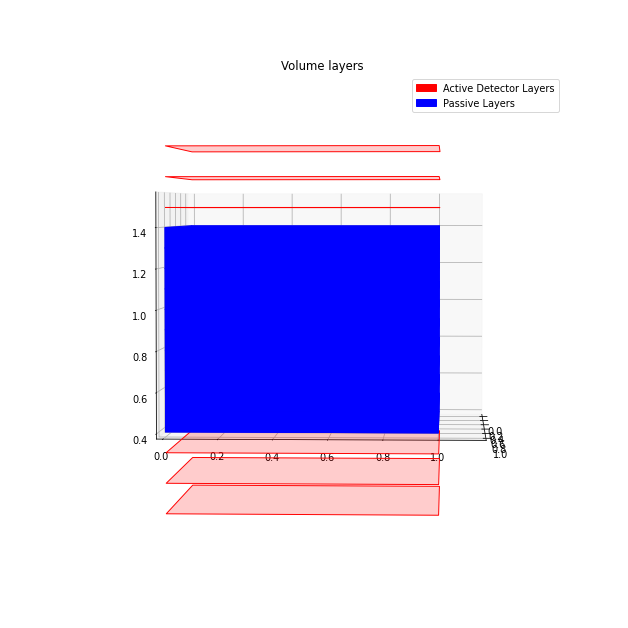

In [42]:
%matplotlib notebook
volume_BigGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

<IPython.core.display.Javascript object>


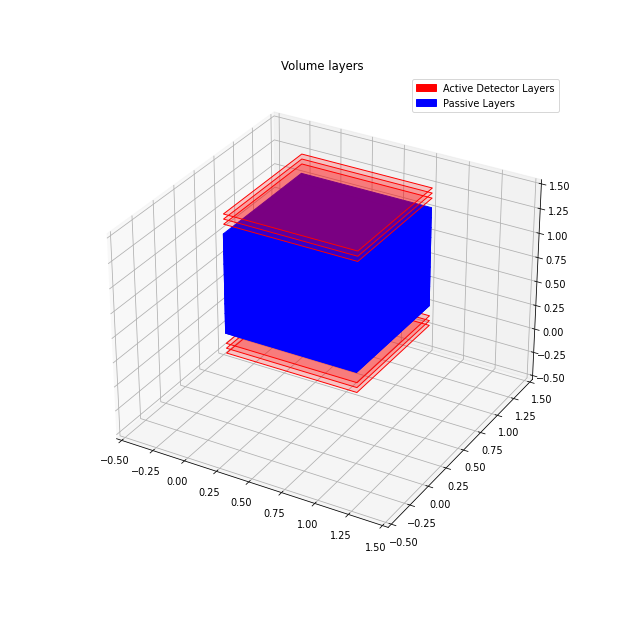

In [6]:
%matplotlib notebook
volume_SmallGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

<IPython.core.display.Javascript object>


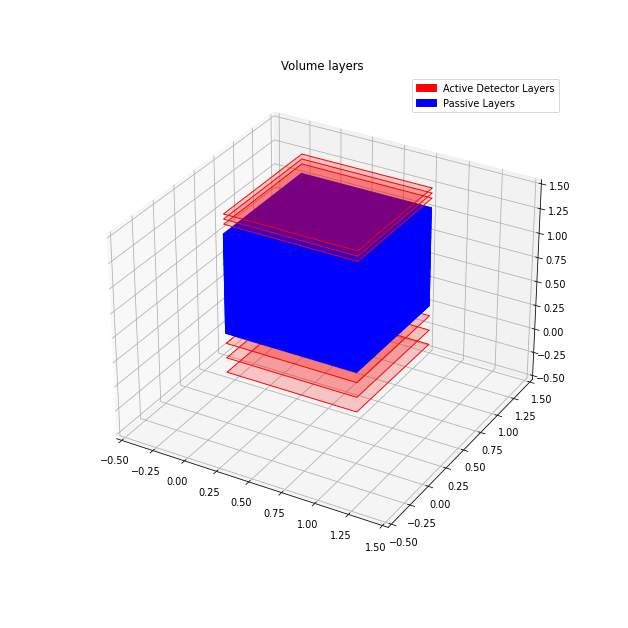

In [7]:
%matplotlib notebook
volume_NotCentred.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

In [8]:
%matplotlib inline

## **Passive volume generation**

Now we'll need to define how to **generate** example **passive volumes**. The furnace ladle is nade of several elements:

 - **Ladle**: a $1\times1\times1 \:[\text{m}^3]$ bucket made of solid steel.

 - **Liquid steel**: The ladle is filled with a **random amount** of liquid steel.

 - **Slag**: Above the liquid steel is a **layer** of **slag**, with a lower density that liquid steel.

 - **Air**: The rest of the ladle is filled with air.


`LadleFurnacePassiveGenerator` class will create layouts based on varying fill-heights of a furnace ladle, with varying levels of slag.

In [9]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [10]:
# Choose volume
volume=volume_BigGapHighRes
# volume=volume_BigGap
# volume=volume_SmallGap
# volume=volume_NotCentred

volume
# volume.get_detectors(), volume.get_passives()

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.8000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

In [13]:
passive_gen = LadleFurnacePassiveGenerator(volume)

For a single training epoch, we'll generate 5 volumes at a range of fill-heights. The 10cm of slag will be present for ever volume.

In [69]:
N_PASSIVES_PER_H = 10
HEIGHTS = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

In [70]:
from tomopt.optimisation import PassiveYielder

In [71]:
trn_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(N_PASSIVES_PER_H) for h in HEIGHTS])

In [72]:
len(trn_passives)

80

Let's visualise one these volume layouts by repurposing one of the visualisers in TomOpt

In [65]:
SelectedVolume = 10
f,t = trn_passives.passives[SelectedVolume]
volume.load_rad_length(f, t)

In [66]:
# Get X0 of all voxels
x0 = volume.get_rad_cube()
x0.shape, x0

(torch.Size([10, 10, 10]),
 tensor([[[1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-0

In [20]:
from tomopt.plotting import plot_pred_true_x0
from tomopt.utils import x0targs_to_classtargs
from tomopt.core import X0

In [21]:
import numpy as np

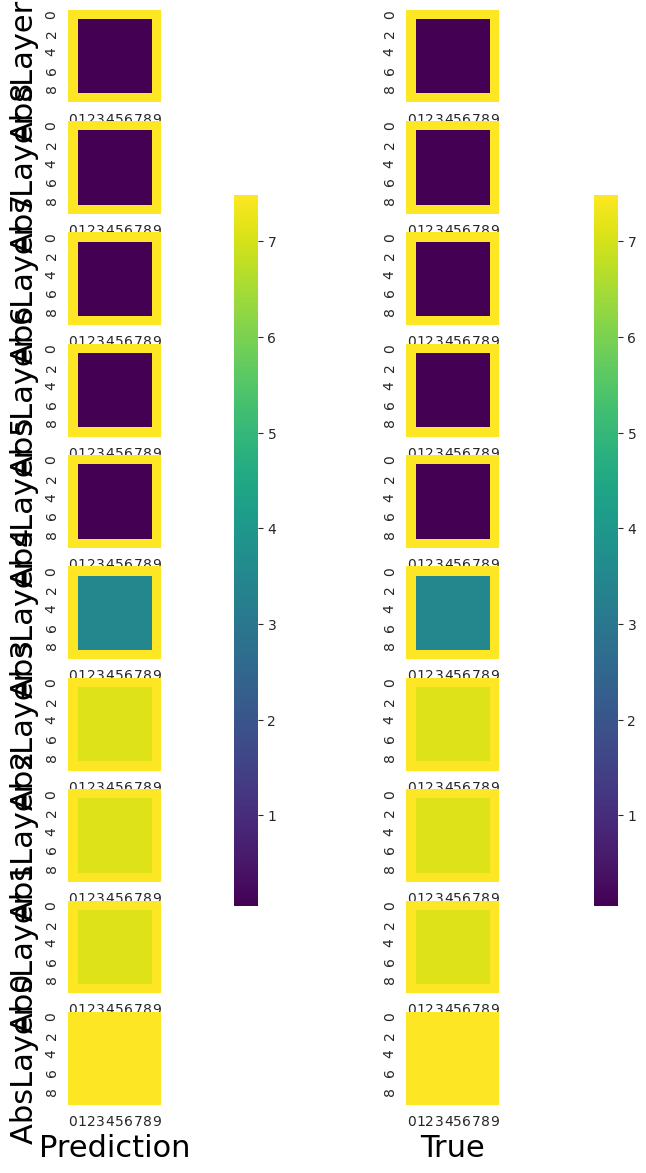

In [67]:
plot_pred_true_x0(1/np.sqrt(volume.get_rad_cube()), 1/np.sqrt(volume.get_rad_cube()))

Ignoring the predicted and true labels, on the right is the layers of the ladle, coloured by voxel material: 

 - Yellow = **ladle** (steel) 
 - Light green = **liquid steel** 
 - Dark green = **Slag** 
 - Blue = **Air**

On the left is the same set of layers, but coloured by material log_10 of the X0. We can see that the metals have very similar X0, but they are slightly distinguishable from the slag.

## **Muon generation and propagation**


In [24]:
from tomopt.muon import MuonGenerator2016 as MuonGenerator

In [25]:
# gen = MuonGenerator.from_volume(volume, fixed_mom=5)
gen = MuonGenerator.from_volume(volume, fixed_mom=None)
gen

Muon generator: x,y range: (-0.40192377427276926, 1.4019237742727693), (-0.40192377427276926, 1.4019237742727693). Energy sampled from 0.5087855416698359-491.5127197474533 GeV.

In [26]:
from tomopt.muon import MuonBatch

In [27]:
muons = MuonBatch(gen(1000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.8119), muons.y[0]=tensor(0.8468), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.7789)'

In [28]:
volume(mu=muons)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.2370), muons.y[0]=tensor(2.5278), muons.z[0]=tensor(0.), muons.theta[0]=tensor(0.7789)'

In [29]:
hits = muons.get_hits()
hits

{'above': {'reco_xyz': tensor([[[ 0.8118,  0.8468,  1.8000],
           [ 0.7639,  0.9869,  1.6500],
           [ 0.7161,  1.1270,  1.5000]],
  
          [[ 0.3731,  0.4408,  1.8000],
           [ 0.3642,  0.5381,  1.6500],
           [ 0.3552,  0.6354,  1.5000]],
  
          [[ 0.6459,  1.4004,  1.8000],
           [ 0.6730,  1.3233,  1.6500],
           [ 0.7001,  1.2466,  1.5000]],
  
          ...,
  
          [[-0.3468,  0.8502,  1.8000],
           [-0.3963,  0.8656,  1.6500],
           [-0.4203,  0.8811,  1.5000]],
  
          [[ 0.6602, -0.1344,  1.8000],
           [ 0.7626, -0.8831,  1.6500],
           [ 0.8650, -0.8649,  1.5000]],
  
          [[ 0.3563,  0.8912,  1.8000],
           [ 0.1223,  0.7459,  1.6500],
           [-0.1116,  0.6006,  1.5000]]], grad_fn=<StackBackward0>),
  'gen_xyz': tensor([[[ 0.8119,  0.8468,  1.8000],
           [ 0.7639,  0.9869,  1.6500],
           [ 0.7160,  1.1270,  1.5000]],
  
          [[ 0.3732,  0.4408,  1.8000],
           [ 0.36

In [30]:
hits['above']['reco_xyz'].shape  # (muons, detector layer, xy)

torch.Size([1000, 3, 3])

In [33]:
from tomopt.inference import ScatterBatch

In [34]:
%%time
sb = ScatterBatch(mu=muons, volume=volume)

CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 408 ms


In [35]:
%%time
sb.poca_xyz, sb.poca_xyz_unc

CPU times: user 5.57 s, sys: 2.25 s, total: 7.82 s
Wall time: 5.49 s


(tensor([[ 0.3236,  0.9752,  0.9754],
         [ 0.8347,  0.8693,  0.7599],
         [ 0.0660,  0.2199,  1.0692],
         ...,
         [ 0.0732,  0.1653,  0.6284],
         [ 1.7168, -3.9051,  0.2521],
         [-1.8861, -0.5013,  0.3625]], grad_fn=<AddBackward0>),
 tensor([[1.4798e-04, 1.2952e-03, 2.0072e-03],
         [3.6284e-05, 1.1990e-04, 3.0526e-04],
         [1.1364e-03, 9.0985e-04, 1.7986e-03],
         ...,
         [1.2161e-04, 8.7820e-04, 1.0620e-03],
         [6.4865e-02, 2.3154e-01, 9.5048e-02],
         [2.4625e-01, 1.5289e-01, 1.5786e-01]], grad_fn=<SqrtBackward0>))

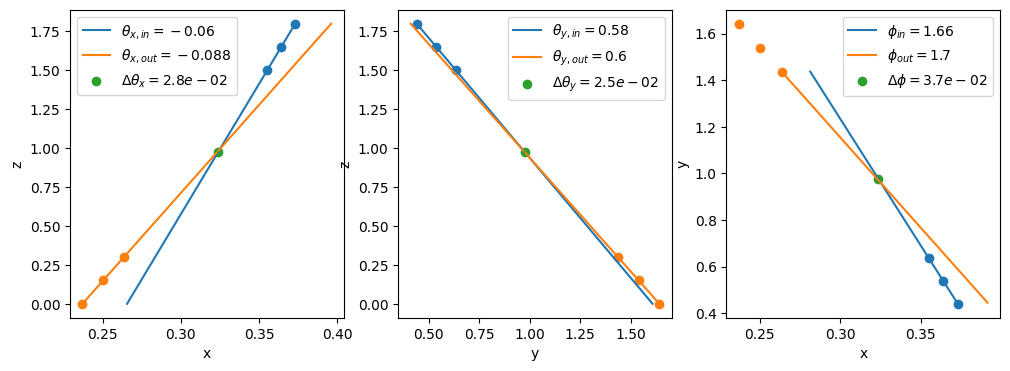

In [36]:
sb.plot_scatter(idx=0)

## **Inference example**

In [37]:
import matplotlib.pyplot as plt

In [38]:
1/np.sqrt(volume.get_rad_cube()[:,4,4])

tensor([7.4911, 7.0870, 3.4898, 0.0574, 0.0574, 0.0574, 0.0574, 0.0574, 0.0574,
        0.0574])

0.1

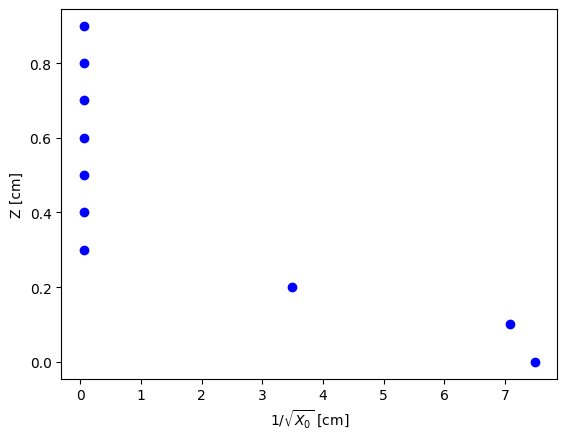

In [39]:
# Get true steel level
plt.plot(1/np.sqrt(volume.get_rad_cube()[:,4,4]), np.arange(0, len(np.sqrt(volume.get_rad_cube()[:,4,4])))*0.1, "bo")
plt.xlabel(r"$1/\sqrt{X_0}$ [cm]")
plt.ylabel("Z [cm]")

PassiveLayerThickness = 0.1
SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
SteelLevel_True

In [40]:
PocaZ = sb.poca_xyz[:, 2].detach().numpy()
FurnaceBottom = 0.5
SteelLevel_Pred = (np.mean(PocaZ)-FurnaceBottom)*2
print("Actual steel level: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level: " + str(round(SteelLevel_Pred, 4)))
np.mean(PocaZ)

Actual steel level: 0.1
Predicted steel level: 0.4295


0.7147374

(0.0, 2.0)

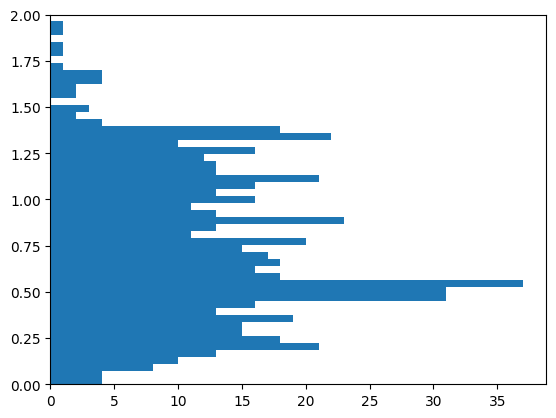

In [61]:
plt.hist(PocaZ, bins=200, orientation="horizontal")
plt.ylim(0,2)


# Run multiple simulations and get POCA mean, as well as true steel level

In [75]:
len(trn_passives)

80

### Generation

In [81]:
GeneratedMuons = 10000
muons = MuonBatch(gen(10000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.0915), muons.y[0]=tensor(0.0739), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.2841)'

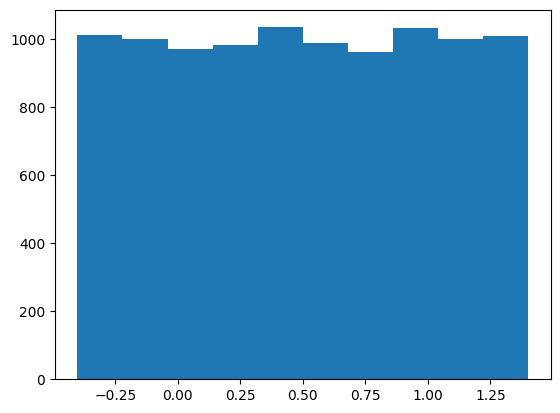

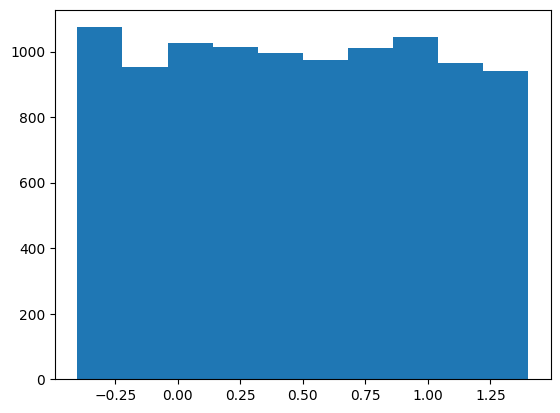

2.25

In [85]:
plt.hist(muons.x)
plt.show()

plt.hist(muons.y)
plt.show()

# Generation surface of 1.5x1.5 m²

1.5*1.5

In [76]:
TrueSteelLevels = np.zeros(100)
TrueSteelLevels[:] = np.nan

PocaZmeans = np.zeros(100)
PocaZmeans[:] = np.nan

for i in progressbar.progressbar(rang:
    print(i)
    
    SelectedVolume = i
    f,t = trn_passives.passives[SelectedVolume]
    volume.load_rad_length(f, t)
    
    # plot_pred_true_x0(1/np.sqrt(volume.get_rad_cube()), 1/np.sqrt(volume.get_rad_cube()))
    
    GeneratedMuons = 10000
    muons = MuonBatch(gen(10000), init_z=1.8)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    volume(mu=muons)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    sb = ScatterBatch(mu=muons, volume=volume)
    sb.poca_xyz, sb.poca_xyz_unc

    PocaZ = sb.poca_xyz[:, 2].detach().numpy()
    PocaZmean = np.mean(PocaZ)
    PocaZmean

    # Get true steel level
    #%matplotlib inline
    #plt.plot(1/np.sqrt(volume.get_rad_cube()[:,4,4]), np.arange(0, len(np.sqrt(volume.get_rad_cube()[:,4,4])))*0.1, "bo")
    #plt.xlabel(r"$1/\sqrt{X_0}$ [cm]")
    #plt.ylabel("Z [cm]")
    #plt.show()

    PassiveLayerThickness = 0.1
    SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
    SteelLevel_True

    #%matplotlib inline
    #plt.hist(PocaZ, bins=100, orientation="horizontal")
    #plt.ylim(0,1.8)
    #plt.show()
    
    TrueSteelLevels[i] = SteelLevel_True
    PocaZmeans[i] = PocaZmean
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

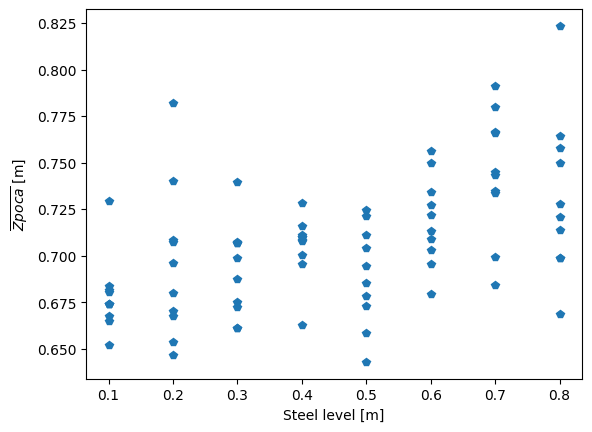

In [80]:
plt.plot(TrueSteelLevels, PocaZmeans, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")

# Model steel level depending on Zpoca mean (1st, and 2nd order)

# Invert and get inference